# Triplet loss

Example showcasing how to use skorch with triplet loss.

At first glance, it might not be quite obvious how to implement something like nets that use contrastive loss or triplet loss with skorch. Here is an example of using triplet loss that could be used as a starting point.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from skorch import NeuralNet
from skorch.utils import data_from_dataset
from skorch.toy import MLPModule
import torch
from torch import nn
from torch.utils.data import Sampler, BatchSampler

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('seaborn')

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare data

Use an artificial dataset consisting of 3 classes.

In [5]:
X, y = make_classification(2000, n_features=50, n_informative=40, n_classes=3)

In [6]:
X = X.astype(np.float32)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

## Custom code

### Sampling of positives and negatives to create triplets

In [8]:
def find_positive(classes, i, sample_weight=None):
    """Given some classes, find a positive sample of the anchor at index `i`

    If you don't want each index to be equally likely (e.g. because some samples
    are too easy), modify the sampling probability through the
    `sample_weight` argument.

    """
    if sample_weight is None:
        sample_weight = np.ones_like(classes)

    is_same = classes == classes[i]
    sample_weight = sample_weight * is_same
    sample_weight[i] = 0  # don't return same index

    p = sample_weight / sample_weight.sum()
    j = np.random.choice(np.arange(len(classes)), p=p)
    return j

In [9]:
def find_negative(classes, i, sample_weight=None):
    """Given some classes, find a negative sample of the anchor at index `i`

    If you don't want each index to be equally likely (e.g. because some samples
    are too easy), modify the sampling probability through the
    `sample_weight` argument.

    """
    if sample_weight is None:
        sample_weight = np.ones_like(classes)

    is_negative = classes != classes[i]
    sample_weight = sample_weight * is_negative
    p = sample_weight / sample_weight.sum()
    j = np.random.choice(np.arange(len(classes)), p=p)
    if classes[i] == classes[j]:
        1/0
    return j

In [10]:
def test_find_positive():
    y = np.random.randint(0, 10, size=200)

    for i in range(200):
        positive = find_positive(y, i)
        assert y[positive] == y[i]
        assert positive != i

In [11]:
def test_find_positive_sample_weight():
    y = np.random.randint(0, 10, size=200)
    sample_weight = np.zeros_like(y)
    sample_weight[::2] = 1.0  # only sample among even indices

    for i in range(200):
        positive = find_positive(y, i, sample_weight=sample_weight)
        assert y[positive] == y[i]
        assert positive != i
        assert positive % 2 == 0

In [12]:
def test_find_negative():
    y = np.random.randint(0, 10, size=200)

    for i in range(200):
        negative = find_negative(y, i)
        assert y[negative] != y[i]

In [13]:
def test_find_negative_sample_weight():
    y = np.random.randint(0, 10, size=200)
    sample_weight = np.zeros_like(y)
    sample_weight[1::2] = 1.0  # only sample among odd indices

    for i in range(200):
        negative = find_negative(y, i, sample_weight=sample_weight)
        assert y[negative] != y[i]
        assert negative % 2 == 1

In [14]:
test_find_positive()

In [15]:
test_find_positive_sample_weight()

In [16]:
test_find_negative()

In [17]:
test_find_negative_sample_weight()

### Custom skorch code

In [18]:
class TripletSampler(torch.utils.data.Sampler):
    """Sampler that returns triplets during training.

    At inference time, only returns the normal samples.

    """
    def __init__(self, data_source, shuffle=False):
        self.data_source = data_source
        self.shuffle = shuffle

        self._indices = np.arange(len(self.data_source))
        if self.shuffle:
            np.random.shuffle(self._indices)

    def __iter__(self):
        _, y = data_from_dataset(self.data_source)
        is_inference = y is None

        for i in self._indices:
            yield i
            if is_inference:
                continue

            i_pos = find_positive(y, i)
            i_neg = find_negative(y, i)
            yield i_pos
            yield i_neg

    def __len__(self):
        return len(self.data_source)

In [19]:
def triplet_dataloader(ds, **kwargs):
    """Returns a DataLoader that uses TripletSampler."""
    shuffle = False
    if 'shuffle' in kwargs:
        shuffle = kwargs.pop('shuffle')

    sampler = TripletSampler(ds, shuffle=shuffle)
    dl = torch.utils.data.DataLoader(ds, sampler=sampler, **kwargs)
    yield from dl

In [20]:
class TripletNet(NeuralNet):
    """Modified NeuralNet that works with TripletMarginLoss"""
    def get_loss(self, y_pred, y_true, X=None, training=False):
        if len(y_pred) % 3 != 0:
            raise ValueError("Batch size must be a multiple of 3, get {} instead.".format(len(y_pred)))

        y_anchor = y_pred[::3]
        y_pos = y_pred[1::3]
        y_neg = y_pred[2::3]
        return self.criterion_(y_anchor, y_pos, y_neg)

## Training

Use a simple MLP and `TripletMarginLoss` to embed the 50-dimensional input space into a 2-dimensional output space. The loss takes care of separating the 3 classes.

In [21]:
net = TripletNet(
    MLPModule,
    module__input_units=X.shape[1], 
    module__output_units=2,
    module__num_hidden=2,
    module__hidden_units=50,

    optimizer=torch.optim.Adam,
    lr=2e-3,
    criterion=nn.TripletMarginLoss,
    criterion__margin=0.5,
    max_epochs=20,
    
    iterator_train=triplet_dataloader,
    iterator_train__shuffle=True,
    iterator_valid=triplet_dataloader,
    batch_size=3*32,  # must be a multiple of 3

    device=device,
)

In [22]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4998        0.4962  0.3032
      2        0.4128        0.4197  0.5175
      3        0.3357        0.3630  0.5319
      4        0.2998        0.3558  0.5316
      5        0.2471        0.3243  0.5252
      6        0.1941        0.2787  0.5334
      7        0.1513        0.2762  0.5500
      8        0.1228        0.2239  0.5575
      9        0.1098        0.2381  0.5749
     10        0.0897        0.1953  0.5555
     11        0.0633        0.2702  0.5672
     12        0.0620        0.2490  0.5609
     13        0.0471        0.1930  0.5801
     14        0.0553        0.2191  0.5705
     15        0.0376        0.2097  0.5824
     16        0.0294        0.2416  0.5833
     17        0.0386        0.1977  0.5917
     18        0.0270        0.2415  0.5924
     19        0.0207        0.2054  0.5811
     20        0.0301        0.1836  0.5887


<class '__main__.TripletNet'>[initialized](
  module_=MLPModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): ReLU()
      (5): Dropout(p=0)
      (6): Linear(in_features=50, out_features=2, bias=True)
    )
  ),
)

## Visualization

Use the hold-out validation data to show that the net learned to separate the 3 classes.

In [23]:
X_emb = net.predict(X_valid)

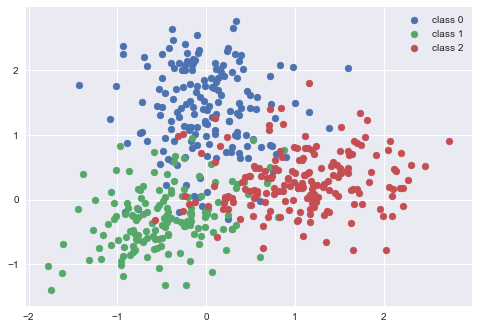

In [24]:
for yi in set(y_valid):
    mask = y_valid == yi
    plt.scatter(X_emb[mask, 0], X_emb[mask, 1], label="class {}".format(yi))
plt.legend()

## Predicting on the embeddings

We train a simple KNN classifier, once on the original input features, `X_valid`, and once on the embedded features, `X_emb`. The classifier is actually more accurate on the embedded features, meaning that the embeddings are indeed useful.

In [25]:
scores = cross_val_score(KNeighborsClassifier(), X_valid, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.6899049316696375

In [26]:
scores = cross_val_score(KNeighborsClassifier(), X_emb, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.8659465240641712

Just for completeness, we show that a dummy classifier performs much worse on the same data, proving that the results are not due to luck.

In [27]:
scores = cross_val_score(DummyClassifier(), X_emb, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.3403184789067142